# Machine Learning Models In Coupon Recommendation

## Introduction

This project aims to predict whether a driver would accept a coupon recommended to him/her in given scenarios(whether the driver will go to use the coupon immediately or before it expires), with database imported from UCI machine learning repository. I will construct models to predict the likelihood of acceptance, then evaluate these models and compare their performances. Models that I will use are logistic regression, decision tree, and random forest.

Link to the database: https://archive-beta.ics.uci.edu/ml/datasets/in+vehicle+coupon+recommendation

## Loading Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import (linear_model, model_selection)
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Loading Dataset

In [2]:
#source of dataset: UCI Machine Learning Repository
cp = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00603/in-vehicle-coupon-recommendation.csv")
cp.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


### Key Attributes Information

#### 1.Contextual attributes


• Destination: No Urgent Place, Home, Work


• Passanger: Alone, Friend(s), Kid(s), Partner


• Time: 2PM, 10AM, 6PM, 7AM, 10PM


• Weather: sunny, rainy, snowy


• Temperature: 30Fo, 55Fo, 80Fo


• toCoupon_GEQ5/15/25min: driving time to coupon location >=5/15/25 minutes: 0 = no, 1 = yes


• direction_same: 0 = not same, 1 = same


• direction_opp: 0 = not opposite, 1 = opposite


#### 2.User attributes


• Gender: male, female


• Age: below 21, 21 to 25, 26 to 30, etc.


• Marital Status: single, married partner, unmarried partner, or widowed


• Number of children: 0, 1, or more than 1


• Education: high school, bachelors degree, associates degree, graduate degree, etc.


• Occupation: architecture & engineering, business & financial, etc.


• Annual income: less than 12500, 12500 -  24999,  25000 - 37499, etc.


• Number of times that he/she goes to a bar: 0, less than 1, 1-3, 4-8 or greater than 8


• Number of times that he/she buys takeaway food: 0, less than 1, 1-3, 4-8 or greater than 8


• Number of times that he/she goes to a coffee house: 0, less than 1, 1-3, 4-8 or greater than 8


• Number of times that he/she eats at a restaurant with average expense less than $20 per person:
0, less than 1, 1-3, 4-8 or greater than 8


• Number of times that he/she goes to a bar: 0, less than 1, 1-3, 4-8 or greater than 8


#### 3. Coupon attributes


• time before it expires: 2 hours or one day


#### 4. Other Columns:



#### Y: 0 = did not accept the coupon, 1 = accepted



#### Coupon: Store type of the coupon: 'Restaurant(<20)', 'Coffee House', 'Carry out & Take away', 'Bar', 'Restaurant(20-50)'







source: https://arxiv.org/pdf/1504.07614.pdf

## Data Exploration

### Preparation

In [69]:
#Drop column 'toCoupon_GEQ5min' since it has same value on every row.
cp = cp.drop(['toCoupon_GEQ5min'], axis=1)

In [70]:
#Check missing values
cp.isnull().sum()

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64

In [71]:
#Drop column 'car' and rows with missing values 
cp = cp.drop(['car'],axis=1)
cp = cp.dropna(axis=0)

#Double check
cp.isnull().any()

destination             False
passanger               False
weather                 False
temperature             False
time                    False
coupon                  False
expiration              False
gender                  False
age                     False
maritalStatus           False
has_children            False
education               False
occupation              False
income                  False
Bar                     False
CoffeeHouse             False
CarryAway               False
RestaurantLessThan20    False
Restaurant20To50        False
toCoupon_GEQ15min       False
toCoupon_GEQ25min       False
direction_same          False
direction_opp           False
Y                       False
dtype: bool

#### Converting Key Categorical Variables to Numerical Variables

In [72]:
#Transfer the expiration time to number of hours: 2h=2, 1d=24
cp['expiration'] = cp['expiration'].replace(['2h','1d'],
                                          [2,24])


#Replace age intervals with their means
cp.age = cp.age.replace(['21', '46', '26', '31', '41', '50plus', '36', 'below21'],
                      [np.array([21,25]).mean(),np.array([46,50]).mean(),
                             np.array([26,30]).mean(),np.array([31,35]).mean(),
                             np.array([41,45]).mean(),np.array([50]).mean(),
                             np.array([36,40]).mean(),np.array([21]).mean()])


#Replace income intervals with their means
cp.income = cp.income.replace(['$62500 - $74999', '$12500 - $24999', '$75000 - $87499',
       '$50000 - $62499', '$37500 - $49999', '$25000 - $37499',
       '$100000 or More', '$87500 - $99999', 'Less than $12500'],
                            [np.array([62500,74999]).mean(),np.array([12500,24999]).mean(),
                             np.array([75000,87499]).mean(),np.array([50000,62499]).mean(),
                             np.array([37500,49999]).mean(),np.array([25000,37499]).mean(),
                             np.array([100000]).mean(),np.array([87500,99999]).mean(),np.array([0,12500]).mean()])

#Replace the frequency intervals with their means: never=0,less1=0.5,1~3=2,4~8=6,gt8=8
for cl in ['Bar','CoffeeHouse','CarryAway','RestaurantLessThan20','Restaurant20To50']:
    cp[cl] = cp[cl].replace(['never','less1','1~3','4~8','gt8'],[0,0.5,2,6,8])

    
#Summary for numerical data
pd.options.display.float_format = "{:.2f}".format
cp.describe()

,temperature,expiration,age,has_children,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12079.00,12079.00,12079.00,12079.00,12079.00,12079.00,12079.00,12079.00,12079.00,12079.00,12079.00,12079.00,12079.00,12079.00,12079.00
mean,63.33,14.31,34.07,0.41,52189.88,1.27,2.22,3.89,3.50,1.29,0.56,0.12,0.22,0.78,0.57
std,19.13,10.92,9.80,0.49,30530.64,2.03,2.65,2.63,2.56,1.72,0.50,0.32,0.41,0.41,0.50
min,30.00,2.00,21.00,0.00,6250.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,55.00,2.00,23.00,0.00,31249.50,0.00,0.50,2.00,2.00,0.50,0.00,0.00,0.00,1.00,0.00
50%,80.00,24.00,33.00,0.00,43749.50,0.50,0.50,2.00,2.00,0.50,1.00,0.00,0.00,1.00,1.00
75%,80.00,24.00,43.00,1.00,81249.50,2.00,2.00,6.00,6.00,2.00,1.00,0.00,0.00,1.00,1.00
max,80.00,24.00,50.00,1.00,100000.00,8.00,8.00,8.00,8.00,8.00,1.00,1.00,1.00,1.00,1.00


### Visualizing the Result of Coupon Acceptance

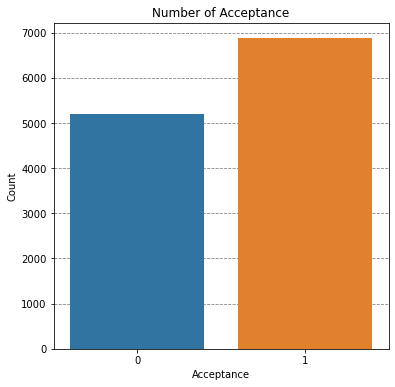

In [73]:
#Number of acceptance
fig, ax = plt.subplots(figsize = (6,6))
sns.countplot(x = "Y", data = cp)

ax.yaxis.grid(color = "gray", linestyle = "dashed")
ax.set_axisbelow(True)

plt.xlabel("Acceptance", size = 10)
plt.ylabel("Count", size = 10)
plt.title("Number of Acceptance")

plt.show()

Text(0.5, 1.0, 'Percentage of Acceptance')

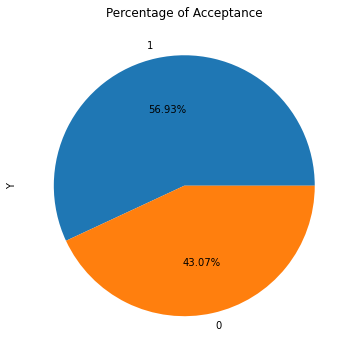

In [74]:
#Percentage of acceptance
fig, ax = plt.subplots(figsize = (16,6))
cp.Y.value_counts().plot(kind = 'pie', ax = ax, autopct = '%1.2f%%')

ax.set_title("Percentage of Acceptance")

As we can see, the percentage of drivers accepting the coupon is larger than rejection based on the dataset.

### Correlation Matrix

In [75]:
#Correlation matrix for numerical variables
cp.corr()

,temperature,expiration,age,has_children,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
temperature,1.00,-0.13,-0.02,-0.02,-0.03,0.01,-0.02,0.01,0.03,-0.02,-0.16,-0.22,0.10,-0.10,0.06
expiration,-0.13,1.00,-0.02,-0.02,-0.02,-0.01,0.00,0.00,-0.01,-0.00,-0.04,0.03,-0.03,0.03,0.13
age,-0.02,-0.02,1.00,0.45,0.09,-0.16,-0.03,-0.03,-0.02,-0.03,0.04,-0.00,-0.03,0.03,-0.06
has_children,-0.02,-0.02,0.45,1.00,0.10,-0.19,0.03,-0.04,-0.05,-0.01,0.08,-0.01,-0.03,0.03,-0.05
income,-0.03,-0.02,0.09,0.10,1.00,-0.01,-0.03,0.01,0.10,0.09,0.02,-0.01,-0.03,0.03,-0.03
Bar,0.01,-0.01,-0.16,-0.19,-0.01,1.00,0.24,0.17,0.17,0.26,-0.02,0.00,-0.01,0.01,0.06
CoffeeHouse,-0.02,0.00,-0.03,0.03,-0.03,0.24,1.00,0.23,0.29,0.23,-0.00,0.00,0.00,-0.00,0.08
CarryAway,0.01,0.00,-0.03,-0.04,0.01,0.17,0.23,1.00,0.40,0.16,-0.01,-0.00,0.00,-0.00,0.03
RestaurantLessThan20,0.03,-0.01,-0.02,-0.05,0.10,0.17,0.29,0.40,1.00,0.38,-0.01,-0.01,-0.01,0.01,0.04
Restaurant20To50,-0.02,-0.00,-0.03,-0.01,0.09,0.26,0.23,0.16,0.38,1.00,-0.01,-0.01,-0.00,0.00,0.07


As we can see, 'expiration' and 'CoffeeHouse' seem to be most positively correlated to coupon acceptance, while driving time to coupon location is most negatively correlated.

### Creating Dummy Variables for Categorical Variables

In [76]:
cp = pd.get_dummies(cp, columns = ['destination', 'passanger', 'weather','time', 'coupon','gender',
                                             'maritalStatus','education', 'occupation'],
                         prefix_sep = '_', drop_first = True)

## Modeling

First of all, split the data into training and testing sets.

In [77]:
#Seperating the target and predictors
X = cp.drop(["Y"], axis = 1)
y = cp["Y"]

#70% training, 30% testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

#Result
print("Number of observations and columns:")
for x,y in zip((X_train, X_test, y_train, y_test),('X_train', 'X_test', 'y_train', 'y_test')):
    print(y,x.shape)

Number of observations and columns:
X_train (8455, 63)
X_test (3624, 63)
y_train (8455,)
y_test (3624,)


### Logistic Regression

In [78]:
#Fitting
lr = linear_model.LogisticRegression()
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

In [79]:
#Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, lr_pred))
print("")

#Report
print("Logistic regression classification report:")
print(metrics.classification_report(y_test, lr_pred))
print("")

#Accuracy
lr_train_acc = lr.score(X_train, y_train)
lr_test_acc = lr.score(X_test, y_test)

print("Logistic regression accuracies:")
print(f"Training accuracy: {lr_train_acc}")
print(f"Testing accuracy: {lr_test_acc}")

Confusion matrix:
[[ 459 1086]
 [ 370 1709]]

Logistic regression classification report:
              precision    recall  f1-score   support

           0       0.55      0.30      0.39      1545
           1       0.61      0.82      0.70      2079

    accuracy                           0.60      3624
   macro avg       0.58      0.56      0.54      3624
weighted avg       0.59      0.60      0.57      3624


Logistic regression accuracies:
Training accuracy: 0.5904198698994678
Testing accuracy: 0.5982339955849889


### Decision Tree

In [84]:
#Fitting
dt = DecisionTreeClassifier(max_depth = 30, max_leaf_nodes = 50)
dt.fit(X_train, y_train)

dt_pred = dt.predict(X_test)

In [85]:
#Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, dt_pred))
print("")

#Report
print("Decision tree report:")
print(metrics.classification_report(y_test, dt_pred))
print("")

#Accuracy
dt_train_acc = dt.score(X_train, y_train)
dt_test_acc = dt.score(X_test, y_test)

print("Decision tree accuracies:")
print(f"Training accuracy: {dt_train_acc}")
print(f"Testing accuracy: {dt_test_acc}")

Confusion matrix:
[[ 999  546]
 [ 480 1599]]

Decision tree report:
              precision    recall  f1-score   support

           0       0.68      0.65      0.66      1545
           1       0.75      0.77      0.76      2079

    accuracy                           0.72      3624
   macro avg       0.71      0.71      0.71      3624
weighted avg       0.72      0.72      0.72      3624


Decision tree accuracies:
Training accuracy: 0.7218214074512123
Testing accuracy: 0.7168874172185431


#### Feature Importance

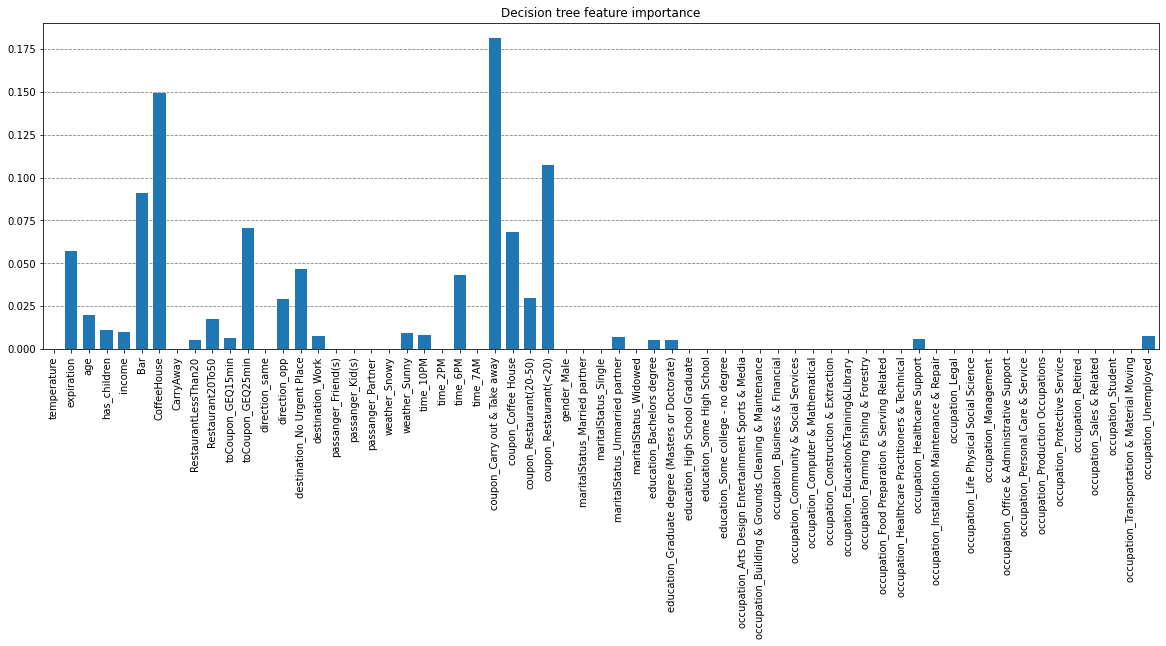

In [86]:
plt.rcParams["figure.figsize"] = [20, 6]
dt_feat = pd.Series(dt.feature_importances_, index = X.columns)
dt_importance = dt_feat.plot(kind = 'bar', width = 0.7)

dt_importance.set_title("Decision tree feature importance")
dt_importance.set_axisbelow(True)
dt_importance.yaxis.grid(color = "gray", linestyle = "dashed")


plt.show()

### Random Forrest

In [87]:
#Fitting 
rf = RandomForestClassifier(n_estimators = 500, min_samples_leaf = 5, random_state = 40)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

In [88]:
#Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, rf_pred))
print("")

#Report
print("Random forest report:")
print(metrics.classification_report(y_test, rf_pred))
print("")

#Accuray
rf_train_acc = rf.score(X_train, y_train)
rf_test_acc = rf.score(X_test, y_test)

print("Random forest accuracies:")
print(f"Training accuracy: {rf_train_acc}")
print(f"Testing accuracy: {rf_test_acc}")

Confusion matrix:
[[ 950  595]
 [ 356 1723]]

Random forest report:
              precision    recall  f1-score   support

           0       0.73      0.61      0.67      1545
           1       0.74      0.83      0.78      2079

    accuracy                           0.74      3624
   macro avg       0.74      0.72      0.73      3624
weighted avg       0.74      0.74      0.73      3624


Random forest accuracies:
Training accuracy: 0.841632170313424
Testing accuracy: 0.7375827814569537


#### Feature Importance

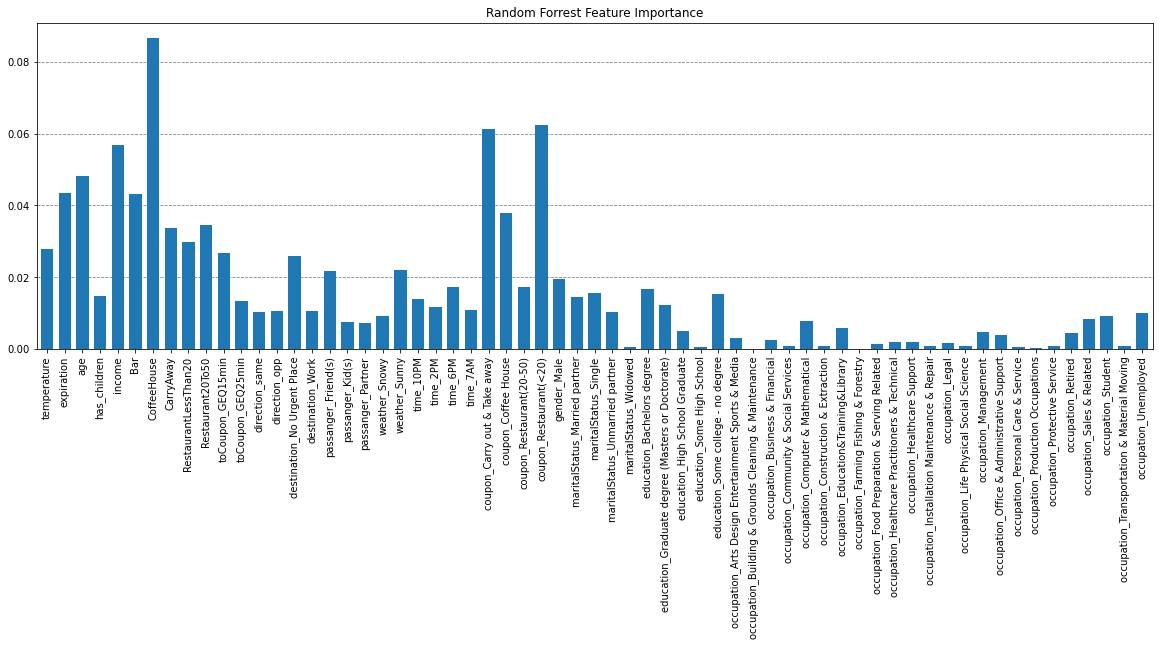

In [89]:
plt.rcParams["figure.figsize"] = [20, 6]
dt_feat = pd.Series(rf.feature_importances_, index = X.columns)
dt_importance = dt_feat.plot(kind = 'bar', width = 0.7)

dt_importance.set_title("Random Forrest Feature Importance")
dt_importance.set_axisbelow(True)
dt_importance.yaxis.grid(color = "gray", linestyle = "dashed")


plt.show()

## ROC Curves and AUC Scores

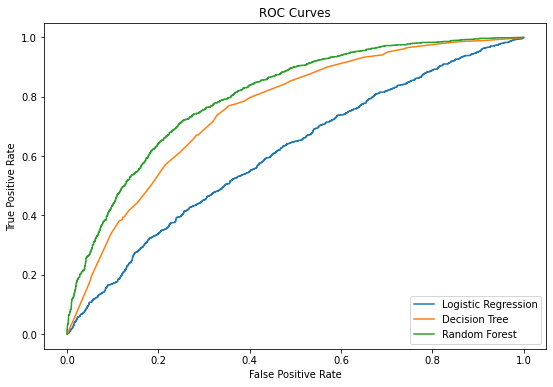

In [90]:
#ROC curves
fig, ax = plt.subplots(figsize = (9,6))
for m in (lr, dt, rf):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, m.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, label = m)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.set_title('ROC Curves')
ax.legend(['Logistic Regression', 'Decision Tree', 'Random Forest'],
           loc = "lower right")
plt.show()


In [91]:
#AUC scores
for m, name in zip((lr, dt, rf),('Logistic Regression', 'Decision Tree', 'Random Forest')):
    auc = metrics.roc_auc_score(y_test,m.predict(X_test))
    print(name, ': AUC is', f'{auc:.5f}')


Logistic Regression : AUC is 0.55956
Decision Tree : AUC is 0.70786
Random Forest : AUC is 0.72183


## Conclusion

By comparing the performance of these three models, I found that Random Forrest is the best model predicting coupon acceptance. Based on the visualization of feature importance, 'frequency of going to coffee house', 'coupon type being take-away food', and 'coupon type being restaurant that costs less than $20 in average' are the most important attributes in coupon recommendation.